In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output
    
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x
    
class TransformerForTimeSeries(nn.Module):
    def __init__(self, d_model=128, num_heads=4, num_layers=2, d_ff=512, dropout=0.1, input_length=50):
        super().__init__()
        self.input_proj = nn.Linear(8, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_seq_length=input_length)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        for layer in self.encoder_layers:
            x = layer(x, None)
        # Lấy vector cuối cùng làm output
        return self.fc_out(x[:, -1, :])


In [18]:
# đọc dữ liệu từ file csv
df = pd.read_csv('E:\DL\VNM.csv', encoding='utf-8')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["KL", "% Thay đổi"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

            Ngày  Đóng cửa    Mở cửa  Cao nhất Thấp nhất
0     21/07/2023  73,500.0  72,500.0  75,000.0  72,400.0
1     20/07/2023  72,700.0  72,600.0  72,900.0  72,300.0
2     19/07/2023  72,600.0  72,500.0  73,000.0  72,400.0
3     18/07/2023  72,400.0  72,500.0  72,600.0  72,200.0
4     17/07/2023  72,300.0  73,000.0  73,600.0  72,200.0
...          ...       ...       ...       ...       ...
2500  16/07/2013  96,528.0  95,139.0  97,222.0  95,139.0
2501  15/07/2013  95,139.0  95,139.0  95,833.0  94,444.0
2502  12/07/2013  95,139.0  94,444.0  95,139.0  93,750.0
2503  11/07/2013  94,444.0  94,444.0  95,139.0  93,750.0
2504  10/07/2013  94,444.0  95,139.0  95,833.0  94,444.0

[2505 rows x 5 columns]


<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\User\AppData\Local\Temp\ipykernel_14924\1141448510.py:2: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv('E:\DL\VNM.csv', encoding='utf-8')


In [19]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
df['Đóng cửa'] = df['Đóng cửa'].str.replace(',', '').astype(float)
df['Mở cửa'] = df['Mở cửa'].str.replace(',', '').astype(float)
df['Cao nhất'] = df['Cao nhất'].str.replace(',', '').astype(float)
df['Thấp nhất'] = df['Thấp nhất'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

In [20]:
import ta
# Tính toán các chỉ báo kỹ thuật
df['SMA_14'] = ta.trend.sma_indicator(df['Đóng cửa'], window=14)
df['EMA_14'] = ta.trend.ema_indicator(df['Đóng cửa'], window=14)
df['RSI'] = ta.momentum.rsi(df['Đóng cửa'], window=14)
macd = ta.trend.macd(df["Đóng cửa"])
df["MACD"] = macd
df["MACD_signal"] = ta.trend.macd_signal(df["Đóng cửa"])

In [21]:
df = df.fillna(0) # Thay thế giá trị NaN bằng 0

In [22]:
df1 = pd.DataFrame(df, columns=['Ngày','Đóng cửa',"Mở cửa",'Cao nhất','Thấp nhất','SMA_14','EMA_14','RSI','MACD'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1

,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất,SMA_14,EMA_14,RSI,MACD
Ngày,,,,,,,,
2013-07-10,94444.0,95139.0,95833.0,94444.0,0.000000,0.000000,0.000000,0.000000
2013-07-11,94444.0,94444.0,95139.0,93750.0,0.000000,0.000000,0.000000,0.000000
2013-07-12,95139.0,94444.0,95139.0,93750.0,0.000000,0.000000,0.000000,0.000000
2013-07-15,95139.0,95139.0,95833.0,94444.0,0.000000,0.000000,0.000000,0.000000
2013-07-16,96528.0,95139.0,97222.0,95139.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-07-17,72300.0,73000.0,73600.0,72200.0,71650.000000,71546.658572,61.069967,1298.104852
2023-07-18,72400.0,72500.0,72600.0,72200.0,71778.571429,71660.437429,61.527924,1250.452056
2023-07-19,72600.0,72500.0,73000.0,72400.0,71828.571429,71785.712439,62.478602,1214.821494


In [23]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 80-20
train_size = int(len(df1) * 0.8)
train_data = df1[:train_size]
test_data = df1[train_size:]

In [24]:
sc_x = MinMaxScaler(feature_range=(0, 1))
sc_y = MinMaxScaler(feature_range=(0, 1))
x_data = sc_x.fit_transform(df1)
y_data = sc_y.fit_transform(df1[["Đóng cửa"]])

In [25]:
x_train, y_train =[],[]
for i in range(50, len(train_data)):
    x_train.append(x_data[i-50:i])
    y_train.append(y_data[i])

In [26]:
x_test, y_test =[],[]
for i in range(len(train_data),len(df1)):
    x_test.append(x_data[i-50:i])
    y_test.append(y_data[i])

In [27]:
x_train = np.array(x_train) 
y_train = np.array(y_train) 
x_test = np.array(x_test) 
y_test = np.array(y_test) 

In [28]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [29]:
model = TransformerForTimeSeries(input_length=50)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [30]:
torch.manual_seed(42)
import copy

#set a number of epochs
epochs = 100


best_loss = float('inf')
best_model_state_dict = None

# Build training and evaluation loop
for epoch in range(epochs):
    model.train()

    # forward
    y_pred = model(x_train)

    # tính loss (ví dụ: MSE)
    loss = criterion(y_pred, y_train)

    # reset gradient
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Đánh giá trên tập test
    model.eval()
    with torch.inference_mode():
        test_pred = model(x_test)

        test_loss = criterion(test_pred, y_test)

    # Ghi lại mô hình có test_loss tốt nhất
    if test_loss.item() < best_loss:
        best_loss = test_loss.item()
        best_model = copy.deepcopy(model.state_dict())  # lưu bản sao tham số tốt nhất

    # In ra mỗi 10 epoch
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")


Epoch: 0 | Train Loss: 0.1361 | Test Loss: 0.0314
Epoch: 20 | Train Loss: 0.0171 | Test Loss: 0.0053
Epoch: 40 | Train Loss: 0.0090 | Test Loss: 0.0017
Epoch: 60 | Train Loss: 0.0067 | Test Loss: 0.0002
Epoch: 80 | Train Loss: 0.0052 | Test Loss: 0.0002


In [31]:
torch.save(best_model, "transformer_weights.pth")

In [32]:
model1 = TransformerForTimeSeries(input_length=50)
model1.load_state_dict(torch.load("transformer_weights.pth"))
model1.eval() 

TransformerForTimeSeries(
  (input_proj): Linear(in_features=8, out_features=128, bias=True)
  (pos_enc): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [33]:
y_train_predict = model1(x_train)
y_test_predict = model1(x_test)

In [34]:
y_train_predict = sc_y.inverse_transform(y_train_predict.detach().numpy().reshape(-1, 1))
y_test_predict = sc_y.inverse_transform(y_test_predict.detach().numpy().reshape(-1, 1))

In [35]:
y_train=sc_y.inverse_transform(y_train)

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_train, y_train_predict)
rmse = np.sqrt(mean_squared_error(y_train, y_train_predict))

print(f"MAE on train set: {mae:.4f}")
print(f"RMSE on train set: {rmse:.4f}")

MAE on train set: 1533.6929
RMSE on train set: 2313.8920


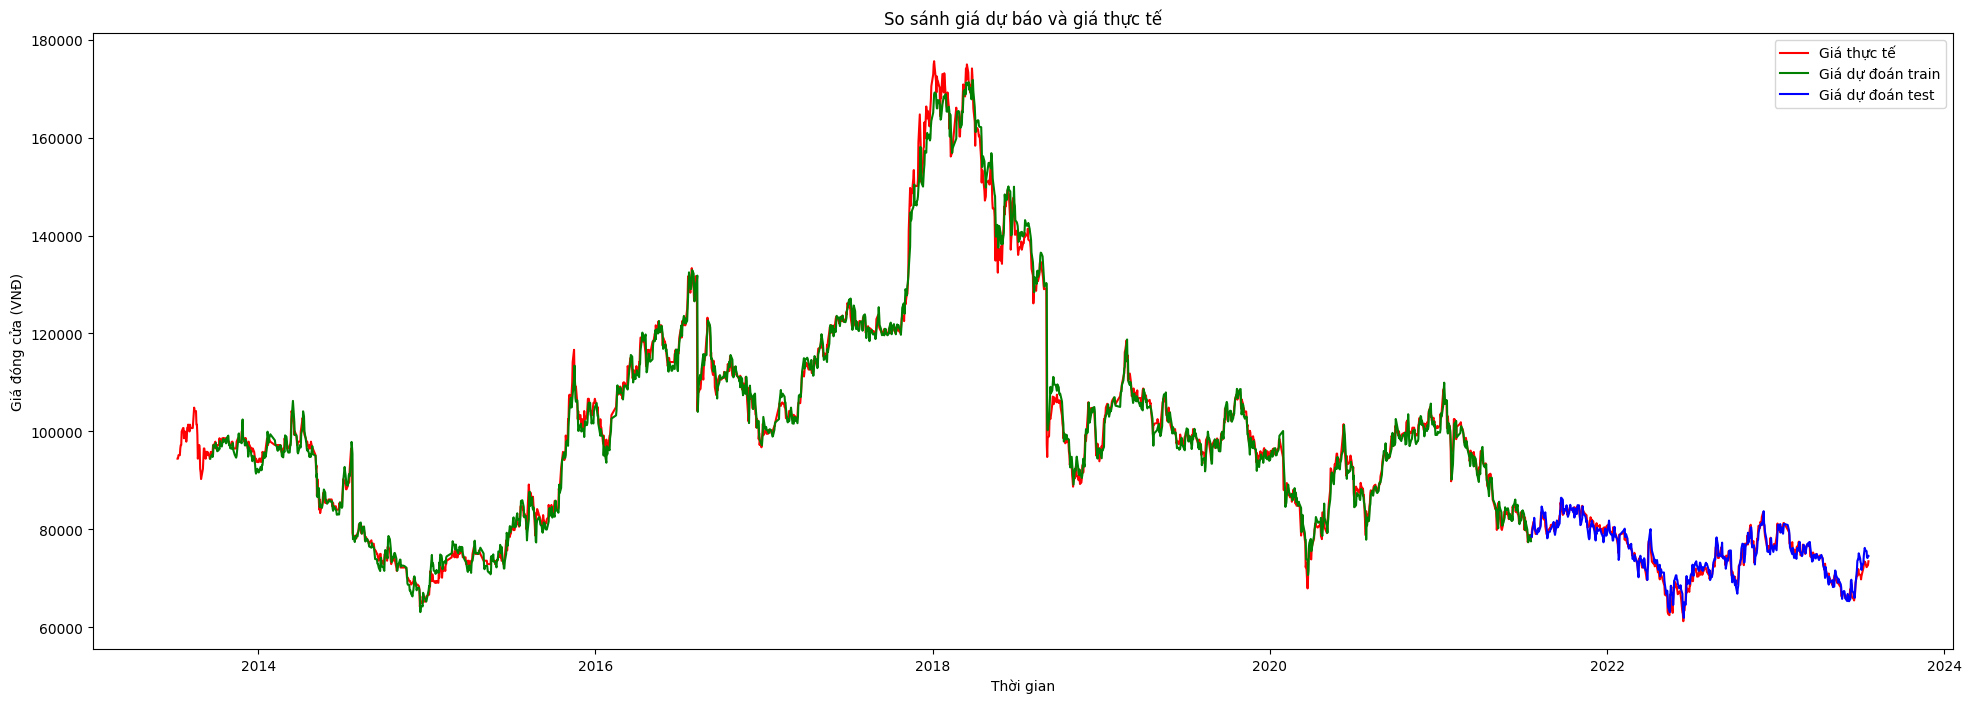

In [37]:
train_data1 = df1[50:len(train_data)].copy()
test_data1 = df1[len(train_data):].copy()

plt.figure(figsize=(24,8))
plt.plot(df1.index, df1['Đóng cửa'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, y_train_predict, label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, y_test_predict, label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()